<a href="https://colab.research.google.com/github/simonchami/Predict-US-Recessions/blob/main/Predict_Recessions_Using_Market_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime
!pip install -U mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.1 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [2]:
# Import data from FRED
start = datetime.datetime(1953,7,1)
symbols = ['DFF', 'DTB3', 'GS1', 'GS5', 'GS10', 'USRECD', 'SP500']
market_data = pdr.fred.FredReader(symbols, freq='monthly', start=start).read()

#Group it by taking the last monthly value for each column
market_data = market_data.groupby(market_data.index.strftime('%Y-%m')).last()

In [4]:
# Import SP500 index data to fill the FRED series (which starts from 2013)
sp500 = pd.read_csv('SPX.csv', index_col='Date')
sp500.index = pd.to_datetime(sp500.index)

# Group it by taking the last closing price for each month
sp500 = sp500['Close'].groupby(sp500.index.strftime('%Y-%m')).last().reset_index()
sp500.set_index('Date', inplace=True)

# Fill the SP500 column with the historic data
market_data['SP500'] = market_data['SP500'].combine_first(sp500['Close'])

In [5]:
# Create the features that will be used in the models

# Labels
market_data['rec_3m'] = market_data['USRECD'].shift(-3)
market_data['rec_6m'] = market_data['USRECD'].shift(-6)
market_data['rec_12m'] = market_data['USRECD'].shift(-12)

# SP500 return
market_data['spx_6m'] = market_data['SP500']/market_data['SP500'].shift(6) - 1
market_data['spx_yoy'] = market_data['SP500']/market_data['SP500'].shift(12) - 1

# Treasury yield curve
market_data['3m_ff'] = market_data['DTB3'] - market_data['DFF']
market_data['1y_ff'] = market_data['GS1'] - market_data['DFF']
market_data['1y_3m'] = market_data['GS1'] - market_data['DTB3']
market_data['5y_1y'] = market_data['GS5'] - market_data['GS1']
market_data['10y_1y'] = market_data['GS10'] - market_data['GS1']
market_data['3m_ff_diff'] = market_data['3m_ff'].diff()
market_data['1y_ff_diff'] = market_data['1y_ff'].diff()
market_data['5y_1y_diff'] = market_data['1y_ff'].diff()
market_data['10y_1y_diff'] = market_data['10y_1y'].diff()
market_data['ff_diff'] = market_data['DFF'].diff()

In [6]:
market_data.tail()

DFF  DTB3   GS1   GS5  GS10  USRECD    SP500  rec_3m  rec_6m  \
DATE                                                                     
2022-10  3.08  4.06  4.43  4.18  3.98       0  3871.98     0.0     NaN   
2022-11  3.83  4.27  4.73  4.06  3.89       0  4080.11     0.0     NaN   
2022-12  4.33  4.30  4.68  3.76  3.62       0  3839.50     NaN     NaN   
2023-01  4.33  4.58  4.69  3.64  3.53       0  4076.60     NaN     NaN   
2023-02  4.58  4.70   NaN   NaN   NaN       0  4079.09     NaN     NaN   

         rec_12m  ...  3m_ff  1y_ff  1y_3m  5y_1y  10y_1y  3m_ff_diff  \
DATE              ...                                                   
2022-10      NaN  ...   0.98   1.35   0.37  -0.25   -0.45        0.84   
2022-11      NaN  ...   0.44   0.90   0.46  -0.67   -0.84       -0.54   
2022-12      NaN  ...  -0.03   0.35   0.38  -0.92   -1.06       -0.47   
2023-01      NaN  ...   0.25   0.36   0.11  -1.05   -1.16        0.28   
2023-02      NaN  ...   0.12    NaN    NaN    NaN     NaN       -0.13   

         1y_ff_diff  5y_1y_diff  10y_1y_diff  ff_diff  
DATE                                                   
2022-10        0.54        0.54        -0.08     0.00  
2022-11       -0.45       -0.45        -0.39     0.75  
2022-12       -0.55       -0.55        -0.22     0.50  
2023-01        0.01        0.01        -0.10     0.00  
2023-02         NaN         NaN          NaN     0.25  

[5 rows x 22 columns]

In [7]:
# Rename columns and drop rows with null values
market_data.columns = ['fed_funds', '3_month', '1_year', '5_year', '10_year', 'rec', 'SP500', 'rec_3m', 'rec_6m', 'rec_12m', 'spx_6m', 'spx_yoy', '3m_ff', '1y_ff', '1y_3m', '5y_1y', '10y_1y', '3m_ff_diff', '1y_ff_diff', '5y_1y_diff', '10y_1y_diff', 'ff_diff']
market_data = market_data[market_data.index >= '1954-08']
market_data = market_data.drop(market_data.index[-1])
market_data.head()

fed_funds  3_month  1_year  5_year  10_year  rec  SP500  rec_3m  \
DATE                                                                       
1954-08       1.44     1.05    0.88    1.90     2.36    0  29.83     0.0   
1954-09       1.44     0.99    1.03    1.96     2.38    0  32.31     0.0   
1954-10       1.13     1.00    1.17    2.02     2.43    0  31.68     0.0   
1954-11       1.38     1.01    1.14    2.09     2.48    0  34.24     0.0   
1954-12       1.44     1.02    1.21    2.16     2.51    0  35.98     0.0   

         rec_6m  rec_12m  ...  3m_ff  1y_ff  1y_3m  5y_1y  10y_1y  3m_ff_diff  \
DATE                      ...                                                   
1954-08     0.0      0.0  ...  -0.39  -0.56  -0.17   1.02    1.48       -0.93   
1954-09     0.0      0.0  ...  -0.45  -0.41   0.04   0.93    1.35       -0.06   
1954-10     0.0      0.0  ...  -0.13   0.04   0.17   0.85    1.26        0.32   
1954-11     0.0      0.0  ...  -0.37  -0.24   0.13   0.95    1.34       -0.24   
1954-12     0.0      0.0  ...  -0.42  -0.23   0.19   0.95    1.30       -0.05   

         1y_ff_diff  5y_1y_diff  10y_1y_diff  ff_diff  
DATE                                                   
1954-08       -1.15       -1.15         0.02     1.19  
1954-09        0.15        0.15        -0.13     0.00  
1954-10        0.45        0.45        -0.09    -0.31  
1954-11       -0.28       -0.28         0.08     0.25  
1954-12        0.01        0.01        -0.04     0.06  

[5 rows x 22 columns]

In [8]:
market_data.isnull().sum()

fed_funds       0
3_month         0
1_year          0
5_year          0
10_year         0
rec             0
SP500           0
rec_3m          2
rec_6m          5
rec_12m        11
spx_6m          0
spx_yoy         0
3m_ff           0
1y_ff           0
1y_3m           0
5y_1y           0
10y_1y          0
3m_ff_diff      0
1y_ff_diff      0
5y_1y_diff      0
10y_1y_diff     0
ff_diff         0
dtype: int64

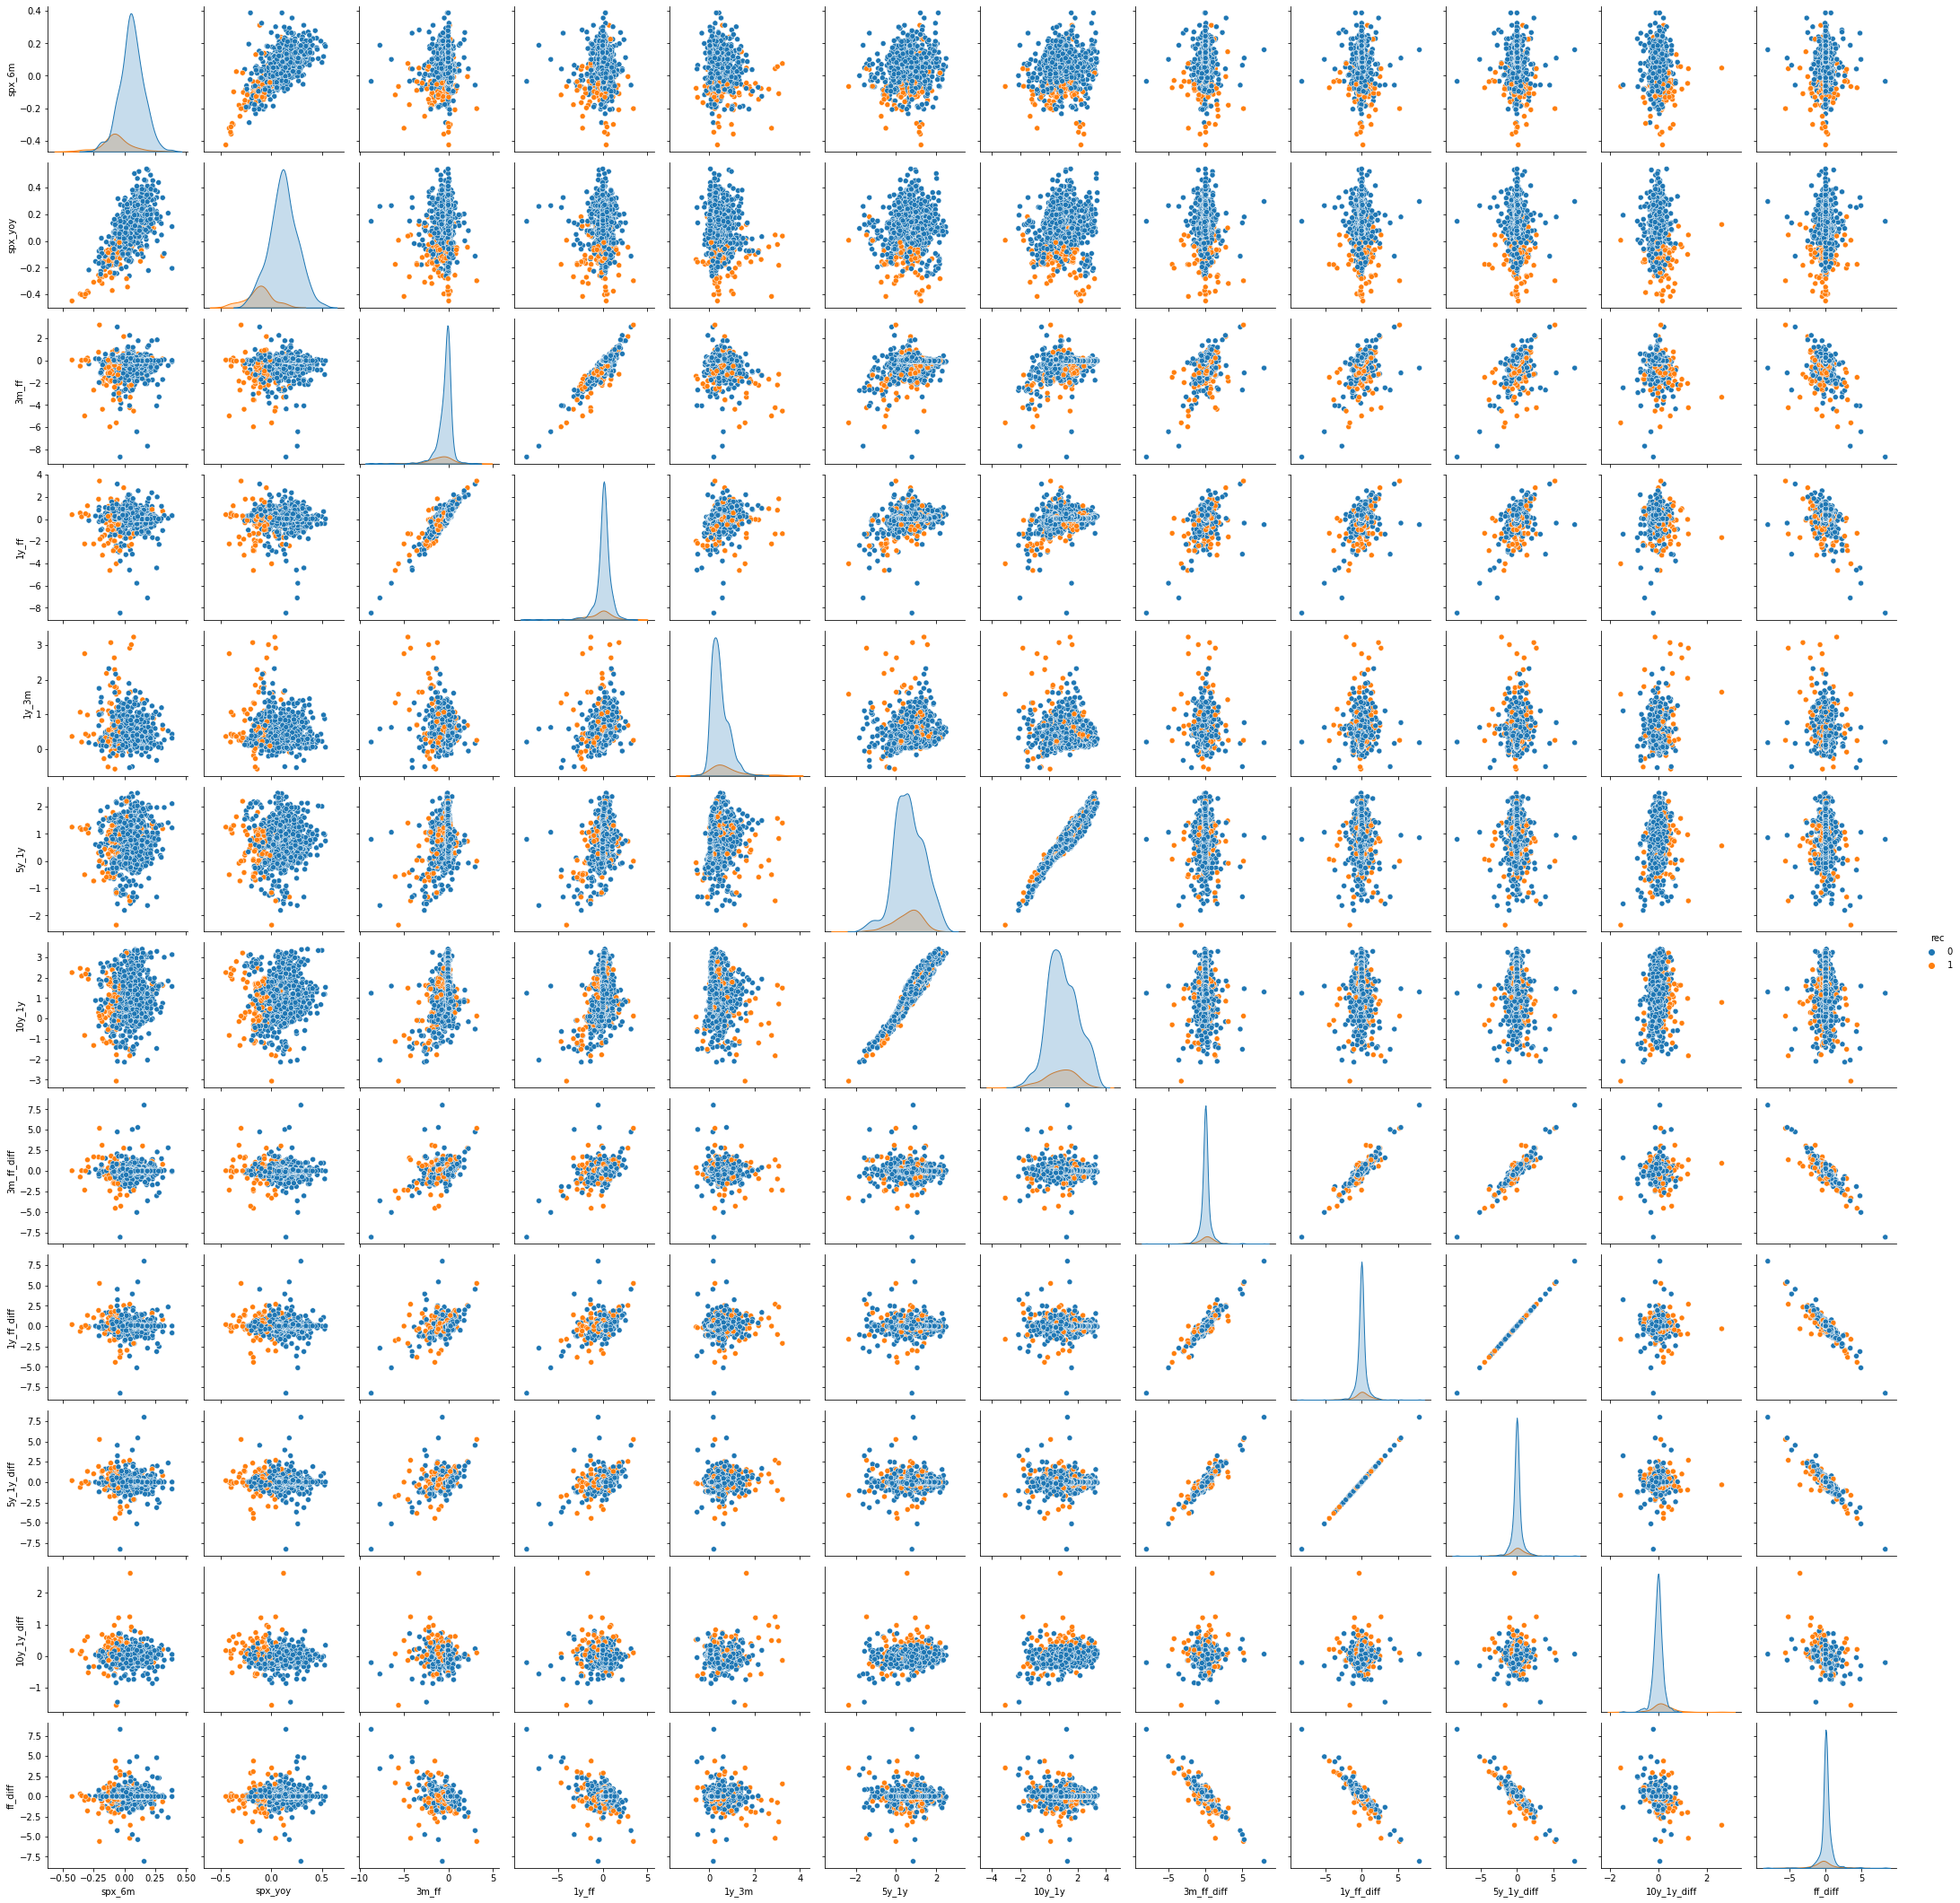

In [9]:
# Pairplot of the features to find patterns to classify recessions
import seaborn as sns
sns.pairplot(market_data[['spx_6m', 'spx_yoy', '3m_ff', '1y_ff', '1y_3m', '5y_1y', '10y_1y', '3m_ff_diff', '1y_ff_diff', '5y_1y_diff', '10y_1y_diff','ff_diff',  'rec']], hue='rec')

In [10]:
# Correlation matrix
market_data[['spx_6m', 'spx_yoy', '3m_ff', '1y_ff', '1y_3m', '5y_1y', '10y_1y', '3m_ff_diff', '1y_ff_diff', '5y_1y_diff', '10y_1y_diff', 'ff_diff', 'rec']].corr()

spx_6m   spx_yoy     3m_ff     1y_ff     1y_3m     5y_1y  \
spx_6m       1.000000  0.688389  0.106962  0.037573 -0.152101  0.137546   
spx_yoy      0.688389  1.000000  0.076297  0.009021 -0.145993  0.067641   
3m_ff        0.106962  0.076297  1.000000  0.890708 -0.284302  0.297000   
1y_ff        0.037573  0.009021  0.890708  1.000000  0.182588  0.359521   
1y_3m       -0.152101 -0.145993 -0.284302  0.182588  1.000000  0.115884   
5y_1y        0.137546  0.067641  0.297000  0.359521  0.115884  1.000000   
10y_1y       0.130906  0.062915  0.309227  0.311447 -0.011953  0.967523   
3m_ff_diff   0.004263 -0.015080  0.457358  0.433694 -0.074514  0.021386   
1y_ff_diff  -0.014985 -0.019044  0.430653  0.468609  0.056885 -0.005696   
5y_1y_diff  -0.014985 -0.019044  0.430653  0.468609  0.056885 -0.005696   
10y_1y_diff -0.038310 -0.089951 -0.036164  0.025809  0.132651  0.138521   
ff_diff      0.034290  0.057485 -0.373406 -0.437433 -0.114951 -0.057534   
rec         -0.389862 -0.496731 -0.222391 -0.121880  0.223948 -0.054529   

               10y_1y  3m_ff_diff  1y_ff_diff  5y_1y_diff  10y_1y_diff  \
spx_6m       0.130906    0.004263   -0.014985   -0.014985    -0.038310   
spx_yoy      0.062915   -0.015080   -0.019044   -0.019044    -0.089951   
3m_ff        0.309227    0.457358    0.430653    0.430653    -0.036164   
1y_ff        0.311447    0.433694    0.468609    0.468609     0.025809   
1y_3m       -0.011953   -0.074514    0.056885    0.056885     0.132651   
5y_1y        0.967523    0.021386   -0.005696   -0.005696     0.138521   
10y_1y       1.000000    0.024743   -0.004603   -0.004603     0.128051   
3m_ff_diff   0.024743    1.000000    0.933548    0.933548     0.075585   
1y_ff_diff  -0.004603    0.933548    1.000000    1.000000     0.013619   
5y_1y_diff  -0.004603    0.933548    1.000000    1.000000     0.013619   
10y_1y_diff  0.128051    0.075585    0.013619    0.013619     1.000000   
ff_diff     -0.057727   -0.891452   -0.909384   -0.909384    -0.327357   
rec         -0.070369    0.024216    0.026387    0.026387     0.261515   

              ff_diff       rec  
spx_6m       0.034290 -0.389862  
spx_yoy      0.057485 -0.496731  
3m_ff       -0.373406 -0.222391  
1y_ff       -0.437433 -0.121880  
1y_3m       -0.114951  0.223948  
5y_1y       -0.057534 -0.054529  
10y_1y      -0.057727 -0.070369  
3m_ff_diff  -0.891452  0.024216  
1y_ff_diff  -0.909384  0.026387  
5y_1y_diff  -0.909384  0.026387  
10y_1y_diff -0.327357  0.261515  
ff_diff      1.000000 -0.123721  
rec         -0.123721  1.000000

In [11]:
# Select inputs for the first model
y = market_data['rec'].dropna()
X = market_data[['spx_6m', 'spx_yoy', '3m_ff', '1y_ff', '1y_3m', '10y_1y', '10y_1y_diff', 'ff_diff']].loc[y.index]

In [12]:
# Classes are highly imbalanced
y.value_counts()

0    719
1    103
Name: rec, dtype: int64

In [13]:
# Set random state variable for future uses
random_state=1

In [14]:
# Split the data into training and testing sets, and transform training data to address class imbalance using ADASYN
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)

In [15]:
# Create the model using a GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=random_state, n_estimators=300, subsample=0.4, min_samples_leaf=8)

# Use a forward floating feature selector, using cross validation and the F1 score to choose between models 
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs1 = SFS(model, k_features = 6, forward=True, floating=True, scoring='f1', cv=5)
sfs1.fit(X_resampled, y_resampled)

# Visualize the different combination of features
sfs1.subsets_

{1: {'feature_idx': (1,),
  'cv_scores': array([0.75925926, 0.82845188, 0.83404255, 0.86919831, 0.81981982]),
  'avg_score': 0.8221543654704087,
  'feature_names': ('spx_yoy',)},
 2: {'feature_idx': (1, 7),
  'cv_scores': array([0.84821429, 0.88034188, 0.87610619, 0.8907563 , 0.87553648]),
  'avg_score': 0.8741910287908269,
  'feature_names': ('spx_yoy', 'ff_diff')},
 3: {'feature_idx': (1, 5, 7),
  'cv_scores': array([0.88105727, 0.92241379, 0.93562232, 0.93277311, 0.88596491]),
  'avg_score': 0.911566280189376,
  'feature_names': ('spx_yoy', '10y_1y', 'ff_diff')},
 4: {'feature_idx': (0, 1, 5, 7),
  'cv_scores': array([0.89285714, 0.94827586, 0.93043478, 0.95798319, 0.91703057]),
  'avg_score': 0.9293163096995409,
  'feature_names': ('spx_6m', 'spx_yoy', '10y_1y', 'ff_diff')},
 5: {'feature_idx': (0, 1, 3, 5, 7),
  'cv_scores': array([0.88888889, 0.94827586, 0.94372294, 0.94468085, 0.94782609]),
  'avg_score': 0.93467892654023,
  'feature_names': ('spx_6m', 'spx_yoy', '1y_ff', '10y_1

In [16]:
# Transform the feature matrix
X_train_sfs = sfs1.transform(X_resampled)
X_test_sfs = sfs1.transform(X_test)

# Fit the model using the chosen features
model.fit(X_train_sfs, y_resampled)

# Print the confusion matrix using the testing data
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, model.predict(X_test_sfs))

array([[135,   9],
       [  1,  20]])

In [17]:
# To evaluate the model, use the classification report for imbalanced data
from imblearn.metrics import classification_report_imbalanced
classification_report_imbalanced(y_test, model.predict(X_test_sfs), output_dict=True)

{0: {'pre': 0.9926470588235294,
  'rec': 0.9375,
  'spe': 0.9523809523809523,
  'f1': 0.9642857142857143,
  'geo': 0.944911182523068,
  'iba': 0.8915284863945577,
  'sup': 144},
 1: {'pre': 0.6896551724137931,
  'rec': 0.9523809523809523,
  'spe': 0.9375,
  'f1': 0.7999999999999999,
  'geo': 0.944911182523068,
  'iba': 0.894185799319728,
  'sup': 21},
 'avg_pre': 0.9540844550986538,
 'avg_rec': 0.9393939393939394,
 'avg_spe': 0.950487012987013,
 'avg_f1': 0.9433766233766233,
 'avg_geo': 0.9449111825230679,
 'avg_iba': 0.8918666898577612,
 'total_support': 165}

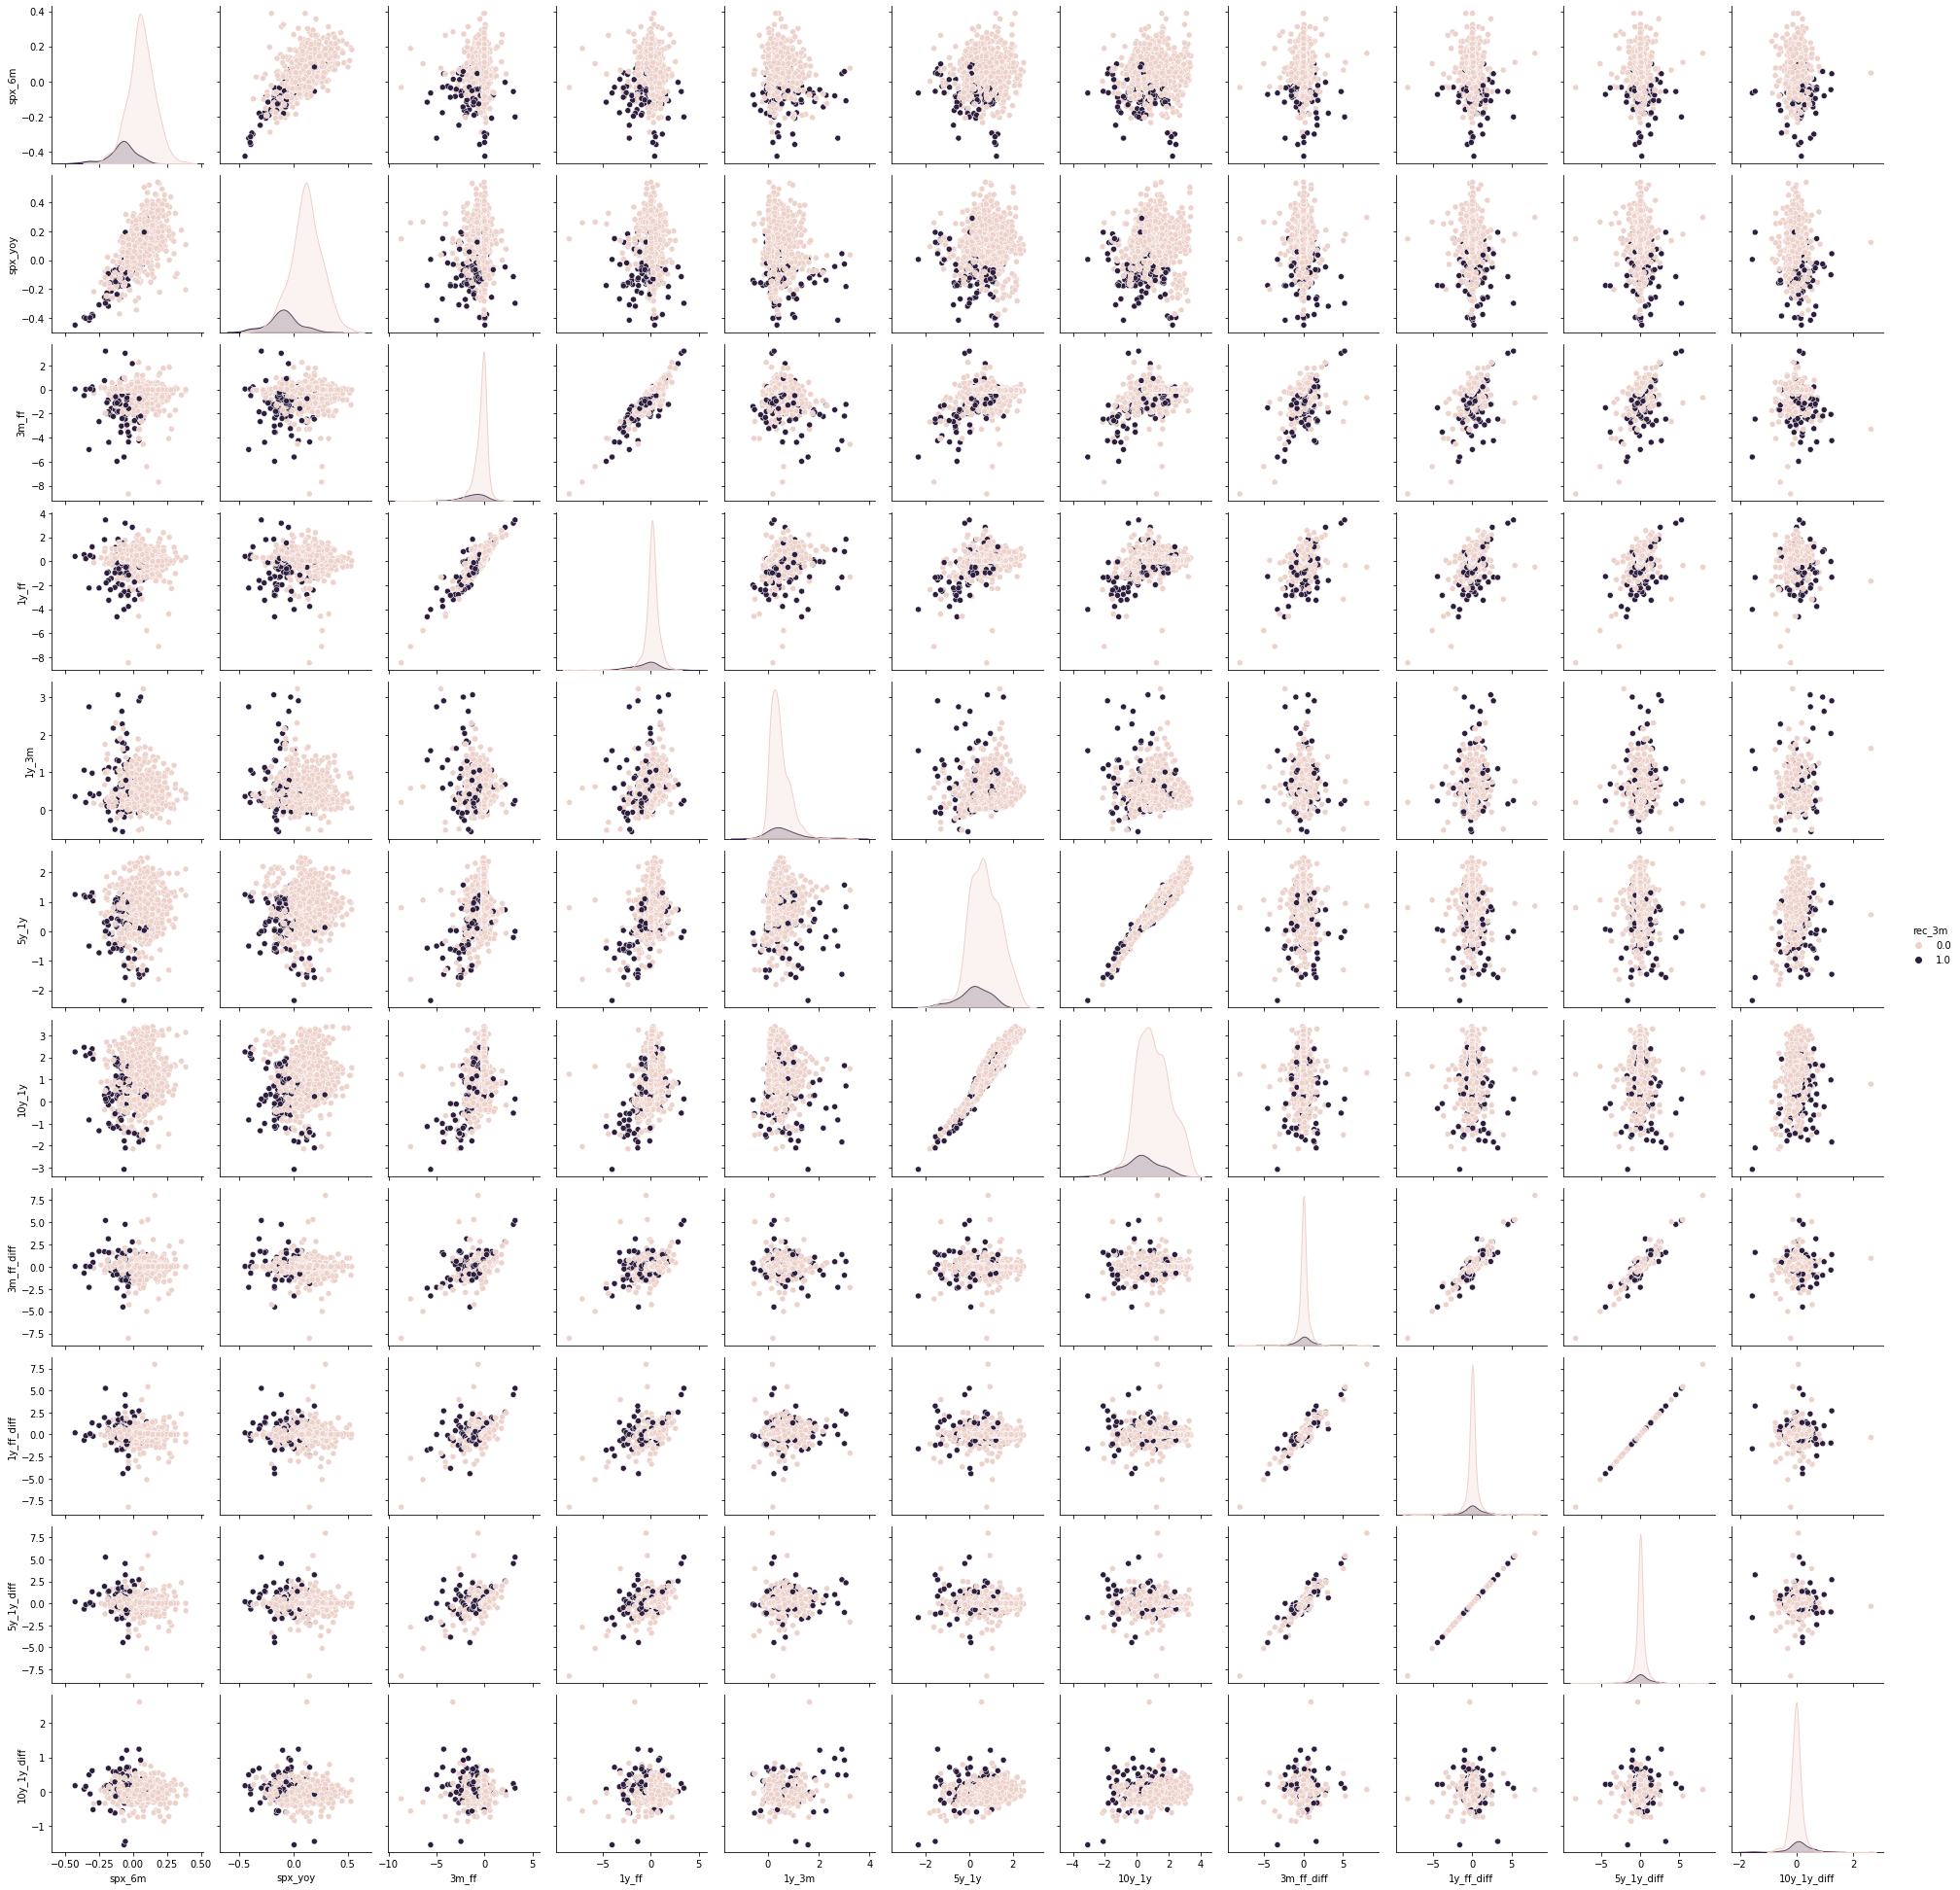

In [18]:
# Pairplot of the features to find patterns to classify recessions with a 3 month anticipation
sns.pairplot(market_data[['spx_6m', 'spx_yoy', '3m_ff', '1y_ff', '1y_3m', '5y_1y', '10y_1y', '3m_ff_diff', '1y_ff_diff', '5y_1y_diff', '10y_1y_diff', 'rec_3m']], hue='rec_3m')

In [19]:
# Correlation matrix
market_data[['spx_6m', 'spx_yoy', '3m_ff', '1y_ff', '1y_3m', '5y_1y', '10y_1y', '3m_ff_diff', '1y_ff_diff', '5y_1y_diff', '10y_1y_diff', 'ff_diff', 'rec_3m']].corr()

spx_6m   spx_yoy     3m_ff     1y_ff     1y_3m     5y_1y  \
spx_6m       1.000000  0.688389  0.106962  0.037573 -0.152101  0.137546   
spx_yoy      0.688389  1.000000  0.076297  0.009021 -0.145993  0.067641   
3m_ff        0.106962  0.076297  1.000000  0.890708 -0.284302  0.297000   
1y_ff        0.037573  0.009021  0.890708  1.000000  0.182588  0.359521   
1y_3m       -0.152101 -0.145993 -0.284302  0.182588  1.000000  0.115884   
5y_1y        0.137546  0.067641  0.297000  0.359521  0.115884  1.000000   
10y_1y       0.130906  0.062915  0.309227  0.311447 -0.011953  0.967523   
3m_ff_diff   0.004263 -0.015080  0.457358  0.433694 -0.074514  0.021386   
1y_ff_diff  -0.014985 -0.019044  0.430653  0.468609  0.056885 -0.005696   
5y_1y_diff  -0.014985 -0.019044  0.430653  0.468609  0.056885 -0.005696   
10y_1y_diff -0.038310 -0.089951 -0.036164  0.025809  0.132651  0.138521   
ff_diff      0.034290  0.057485 -0.373406 -0.437433 -0.114951 -0.057534   
rec_3m      -0.437593 -0.444851 -0.286092 -0.213339  0.168690 -0.245471   

               10y_1y  3m_ff_diff  1y_ff_diff  5y_1y_diff  10y_1y_diff  \
spx_6m       0.130906    0.004263   -0.014985   -0.014985    -0.038310   
spx_yoy      0.062915   -0.015080   -0.019044   -0.019044    -0.089951   
3m_ff        0.309227    0.457358    0.430653    0.430653    -0.036164   
1y_ff        0.311447    0.433694    0.468609    0.468609     0.025809   
1y_3m       -0.011953   -0.074514    0.056885    0.056885     0.132651   
5y_1y        0.967523    0.021386   -0.005696   -0.005696     0.138521   
10y_1y       1.000000    0.024743   -0.004603   -0.004603     0.128051   
3m_ff_diff   0.024743    1.000000    0.933548    0.933548     0.075585   
1y_ff_diff  -0.004603    0.933548    1.000000    1.000000     0.013619   
5y_1y_diff  -0.004603    0.933548    1.000000    1.000000     0.013619   
10y_1y_diff  0.128051    0.075585    0.013619    0.013619     1.000000   
ff_diff     -0.057727   -0.891452   -0.909384   -0.909384    -0.327357   
rec_3m      -0.245617    0.043587    0.072416    0.072416     0.163148   

              ff_diff    rec_3m  
spx_6m       0.034290 -0.437593  
spx_yoy      0.057485 -0.444851  
3m_ff       -0.373406 -0.286092  
1y_ff       -0.437433 -0.213339  
1y_3m       -0.114951  0.168690  
5y_1y       -0.057534 -0.245471  
10y_1y      -0.057727 -0.245617  
3m_ff_diff  -0.891452  0.043587  
1y_ff_diff  -0.909384  0.072416  
5y_1y_diff  -0.909384  0.072416  
10y_1y_diff -0.327357  0.163148  
ff_diff      1.000000 -0.123871  
rec_3m      -0.123871  1.000000

In [20]:
# Select inputs for the second model
y_2 = market_data['rec_3m'].dropna()
X_2 = market_data[['spx_6m', 'spx_yoy', '3m_ff', '1y_ff', '1y_3m', '5y_1y', '10y_1y', '10y_1y_diff', 'ff_diff']].loc[y_2.index]

# Split the data into training and testing sets, and transform training data to address class imbalance using ADASYN
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=random_state, stratify=y_2)
X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)

In [21]:
# Create the model using a GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
model2 = GradientBoostingClassifier(random_state=random_state, n_estimators=500, subsample=0.4, min_samples_leaf=8)

# Use a forward floating feature selector, using cross validation and the F1 score to choose between models 
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs2 = SFS(model2, k_features = 6, forward=True, floating=True, scoring='f1', cv=5)
sfs2.fit(X_resampled, y_resampled)

# Visualize the different combination of features
sfs2.subsets_


{1: {'feature_idx': (7,),
  'cv_scores': array([0.63589744, 0.83870968, 0.88584475, 0.78846154, 0.8195122 ]),
  'avg_score': 0.7936851191517456,
  'feature_names': ('10y_1y_diff',)},
 2: {'feature_idx': (0, 7),
  'cv_scores': array([0.77678571, 0.81057269, 0.82845188, 0.79816514, 0.82666667]),
  'avg_score': 0.8081284177273835,
  'feature_names': ('spx_6m', '10y_1y_diff')},
 3: {'feature_idx': (0, 5, 7),
  'cv_scores': array([0.89777778, 0.86580087, 0.88259109, 0.86462882, 0.91774892]),
  'avg_score': 0.8857094950811337,
  'feature_names': ('spx_6m', '5y_1y', '10y_1y_diff')},
 4: {'feature_idx': (0, 1, 5, 7),
  'cv_scores': array([0.89451477, 0.89686099, 0.91139241, 0.9       , 0.95614035]),
  'avg_score': 0.9117817020840118,
  'feature_names': ('spx_6m', 'spx_yoy', '5y_1y', '10y_1y_diff')},
 5: {'feature_idx': (0, 1, 2, 5, 7),
  'cv_scores': array([0.91845494, 0.90350877, 0.91983122, 0.92165899, 0.97413793]),
  'avg_score': 0.9275183696780864,
  'feature_names': ('spx_6m', 'spx_yoy', 

In [22]:
# Transform the features
X_train_sfs = sfs2.transform(X_resampled)
X_test_sfs = sfs2.transform(X_test)

# Fit the model using the chosen features
model2.fit(X_train_sfs, y_resampled)

# Print the confusion matrix using the testing data
confusion_matrix(y_test, model2.predict(X_test_sfs))

array([[129,  14],
       [  5,  16]])

In [23]:
# To evaluate the model, use the classification report for imbalanced data
classification_report_imbalanced(y_test, model2.predict(X_test_sfs), output_dict=True)

{0.0: {'pre': 0.9626865671641791,
  'rec': 0.9020979020979021,
  'spe': 0.7619047619047619,
  'f1': 0.9314079422382671,
  'geo': 0.8290432360936836,
  'iba': 0.6969483397055823,
  'sup': 143},
 1.0: {'pre': 0.5333333333333333,
  'rec': 0.7619047619047619,
  'spe': 0.9020979020979021,
  'f1': 0.6274509803921569,
  'geo': 0.8290432360936836,
  'iba': 0.677677034919792,
  'sup': 21},
 'avg_pre': 0.907708409173644,
 'avg_rec': 0.8841463414634146,
 'avg_spe': 0.7798563225392494,
 'avg_f1': 0.8924866239530945,
 'avg_geo': 0.8290432360936837,
 'avg_iba': 0.6944806726293531,
 'total_support': 164}

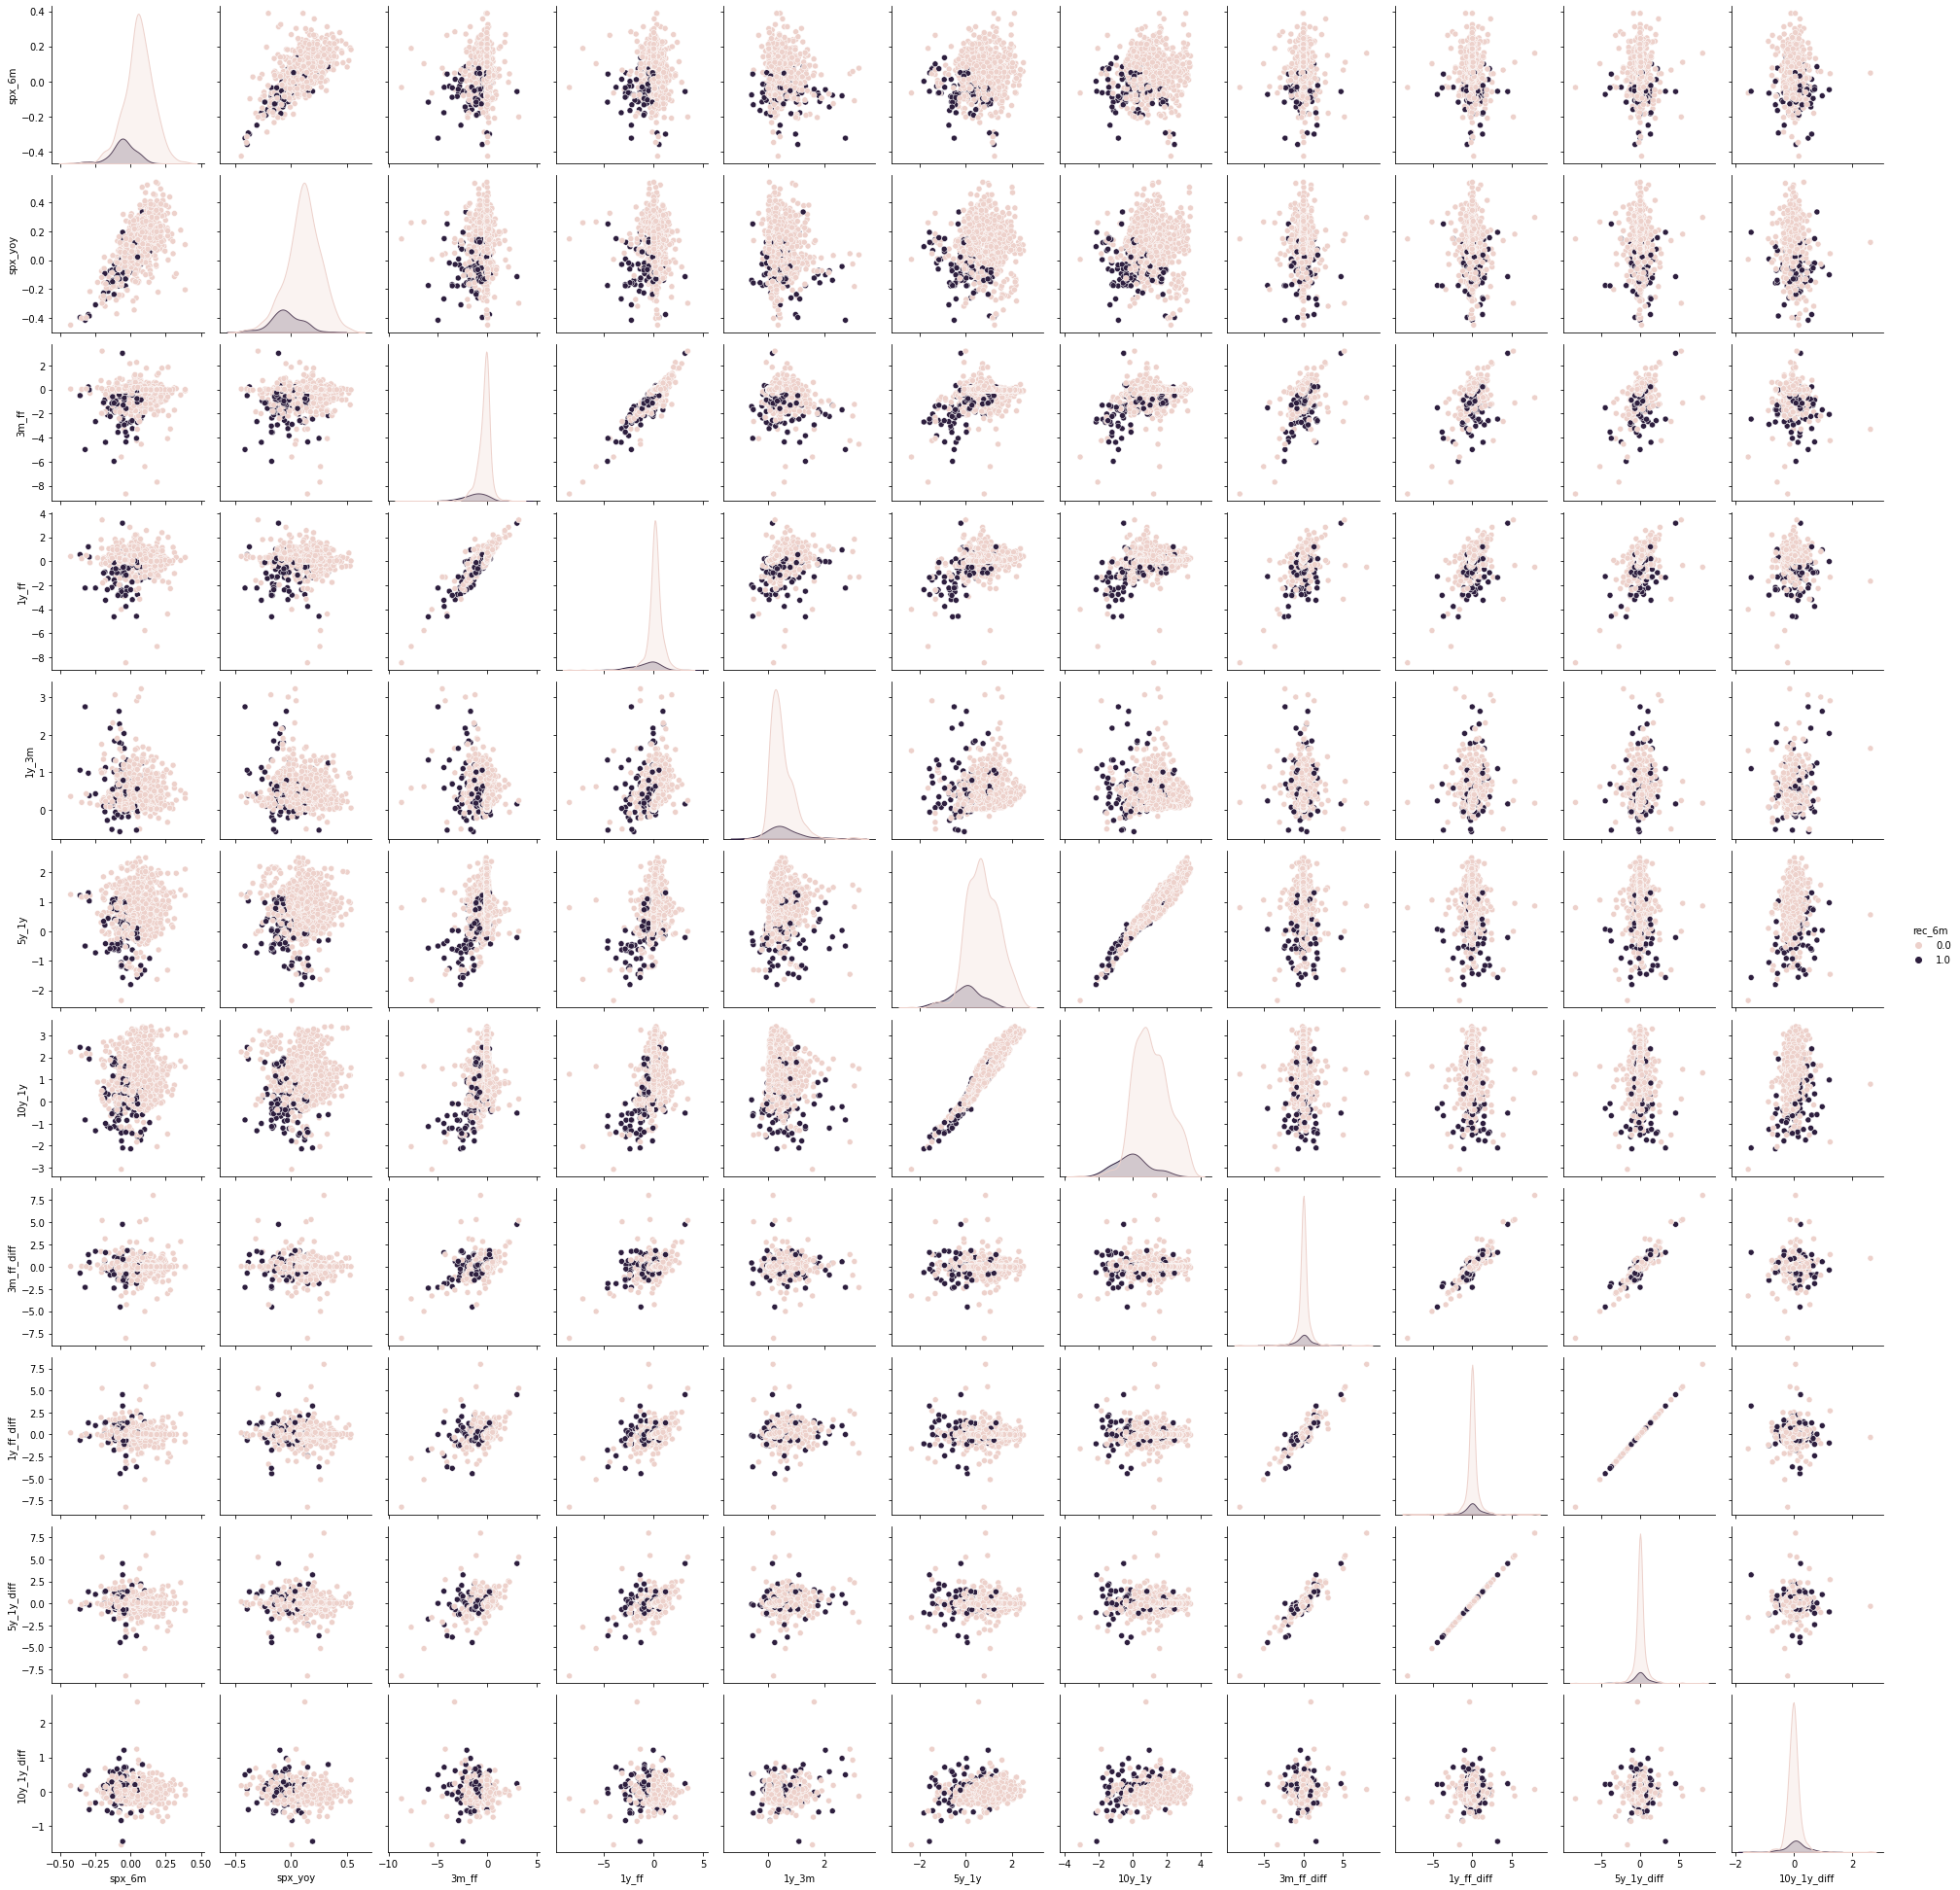

In [24]:
# Pairplot of the features to find patterns to classify recessions with a 6 month anticipation
sns.pairplot(market_data[['spx_6m', 'spx_yoy', '3m_ff', '1y_ff', '1y_3m', '5y_1y', '10y_1y', '3m_ff_diff', '1y_ff_diff', '5y_1y_diff', '10y_1y_diff', 'rec_6m']], hue='rec_6m')

In [25]:
# Correlation matrix
market_data[['spx_6m', 'spx_yoy', '3m_ff', '1y_ff', '1y_3m', '5y_1y', '10y_1y', '3m_ff_diff', '1y_ff_diff', '5y_1y_diff', '10y_1y_diff', 'ff_diff', 'rec_6m']].corr()

spx_6m   spx_yoy     3m_ff     1y_ff     1y_3m     5y_1y  \
spx_6m       1.000000  0.688389  0.106962  0.037573 -0.152101  0.137546   
spx_yoy      0.688389  1.000000  0.076297  0.009021 -0.145993  0.067641   
3m_ff        0.106962  0.076297  1.000000  0.890708 -0.284302  0.297000   
1y_ff        0.037573  0.009021  0.890708  1.000000  0.182588  0.359521   
1y_3m       -0.152101 -0.145993 -0.284302  0.182588  1.000000  0.115884   
5y_1y        0.137546  0.067641  0.297000  0.359521  0.115884  1.000000   
10y_1y       0.130906  0.062915  0.309227  0.311447 -0.011953  0.967523   
3m_ff_diff   0.004263 -0.015080  0.457358  0.433694 -0.074514  0.021386   
1y_ff_diff  -0.014985 -0.019044  0.430653  0.468609  0.056885 -0.005696   
5y_1y_diff  -0.014985 -0.019044  0.430653  0.468609  0.056885 -0.005696   
10y_1y_diff -0.038310 -0.089951 -0.036164  0.025809  0.132651  0.138521   
ff_diff      0.034290  0.057485 -0.373406 -0.437433 -0.114951 -0.057534   
rec_6m      -0.344621 -0.328529 -0.321152 -0.295856  0.070275 -0.353843   

               10y_1y  3m_ff_diff  1y_ff_diff  5y_1y_diff  10y_1y_diff  \
spx_6m       0.130906    0.004263   -0.014985   -0.014985    -0.038310   
spx_yoy      0.062915   -0.015080   -0.019044   -0.019044    -0.089951   
3m_ff        0.309227    0.457358    0.430653    0.430653    -0.036164   
1y_ff        0.311447    0.433694    0.468609    0.468609     0.025809   
1y_3m       -0.011953   -0.074514    0.056885    0.056885     0.132651   
5y_1y        0.967523    0.021386   -0.005696   -0.005696     0.138521   
10y_1y       1.000000    0.024743   -0.004603   -0.004603     0.128051   
3m_ff_diff   0.024743    1.000000    0.933548    0.933548     0.075585   
1y_ff_diff  -0.004603    0.933548    1.000000    1.000000     0.013619   
5y_1y_diff  -0.004603    0.933548    1.000000    1.000000     0.013619   
10y_1y_diff  0.128051    0.075585    0.013619    0.013619     1.000000   
ff_diff     -0.057727   -0.891452   -0.909384   -0.909384    -0.327357   
rec_6m      -0.346585   -0.011950    0.011037    0.011037     0.103633   

              ff_diff    rec_6m  
spx_6m       0.034290 -0.344621  
spx_yoy      0.057485 -0.328529  
3m_ff       -0.373406 -0.321152  
1y_ff       -0.437433 -0.295856  
1y_3m       -0.114951  0.070275  
5y_1y       -0.057534 -0.353843  
10y_1y      -0.057727 -0.346585  
3m_ff_diff  -0.891452 -0.011950  
1y_ff_diff  -0.909384  0.011037  
5y_1y_diff  -0.909384  0.011037  
10y_1y_diff -0.327357  0.103633  
ff_diff      1.000000 -0.026793  
rec_6m      -0.026793  1.000000

In [26]:
# Select inputs for the third model
y_3 = market_data['rec_6m'].dropna()
X_3 = market_data[['spx_6m', 'spx_yoy', '3m_ff', '1y_ff', '5y_1y', '10y_1y', '10y_1y_diff']].loc[y_3.index]

# Split the data into training and testing sets, and transform training data to address class imbalance using ADASYN
X_train, X_test, y_train, y_test = train_test_split(X_3, y_3, test_size=0.2, random_state=random_state, stratify=y_3)
X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)

In [27]:
# Create the model using a GradientBoostingClassifier
model3 = GradientBoostingClassifier(random_state=random_state, n_estimators=500, subsample=0.4, min_samples_leaf=8)

# Use a forward floating feature selector, using cross validation and the F1 score to choose between models 
sfs3 = SFS(model3, k_features = 6, forward=True, floating=True, scoring='f1', cv=5)
sfs3.fit(X_resampled, y_resampled)

# Visualize the different combination of features
sfs3.subsets_

{1: {'feature_idx': (6,),
  'cv_scores': array([0.62222222, 0.76851852, 0.78640777, 0.79047619, 0.81385281]),
  'avg_score': 0.7562955024120073,
  'feature_names': ('10y_1y_diff',)},
 2: {'feature_idx': (4, 6),
  'cv_scores': array([0.8       , 0.74654378, 0.79279279, 0.78733032, 0.83193277]),
  'avg_score': 0.7917199322891922,
  'feature_names': ('5y_1y', '10y_1y_diff')},
 3: {'feature_idx': (1, 4, 6),
  'cv_scores': array([0.92116183, 0.87037037, 0.85333333, 0.85840708, 0.85714286]),
  'avg_score': 0.8720830932437439,
  'feature_names': ('spx_yoy', '5y_1y', '10y_1y_diff')},
 4: {'feature_idx': (1, 2, 4, 6),
  'cv_scores': array([0.92372881, 0.90825688, 0.87111111, 0.88105727, 0.8907563 ]),
  'avg_score': 0.8949820753295707,
  'feature_names': ('spx_yoy', '3m_ff', '5y_1y', '10y_1y_diff')},
 5: {'feature_idx': (1, 2, 3, 4, 5),
  'cv_scores': array([0.92436975, 0.95575221, 0.91479821, 0.90497738, 0.91452991]),
  'avg_score': 0.9228854913324185,
  'feature_names': ('spx_yoy', '3m_ff', '1

In [28]:
# Transform the features
X_train_sfs = sfs3.transform(X_resampled)
X_test_sfs = sfs3.transform(X_test)

# Fit the model using the chosen features
model3.fit(X_train_sfs, y_resampled)

# Print the confusion matrix using the testing data
confusion_matrix(y_test, model3.predict(X_test_sfs))

array([[127,  16],
       [  7,  14]])

In [29]:
# To evaluate the model, use the classification report for imbalanced data
classification_report_imbalanced(y_test, model3.predict(X_test_sfs), output_dict=True)

{0.0: {'pre': 0.9477611940298507,
  'rec': 0.8881118881118881,
  'spe': 0.6666666666666666,
  'f1': 0.9169675090252708,
  'geo': 0.7694638341563507,
  'iba': 0.6051858009899966,
  'sup': 143},
 1.0: {'pre': 0.4666666666666667,
  'rec': 0.6666666666666666,
  'spe': 0.8881118881118881,
  'f1': 0.5490196078431373,
  'geo': 0.7694638341563507,
  'iba': 0.5789633831591872,
  'sup': 21},
 'avg_pre': 0.8861576265016383,
 'avg_rec': 0.8597560975609756,
 'avg_spe': 0.6950224572175792,
 'avg_f1': 0.8698522289958514,
 'avg_geo': 0.7694638341563507,
 'avg_iba': 0.6018280523653198,
 'total_support': 164}

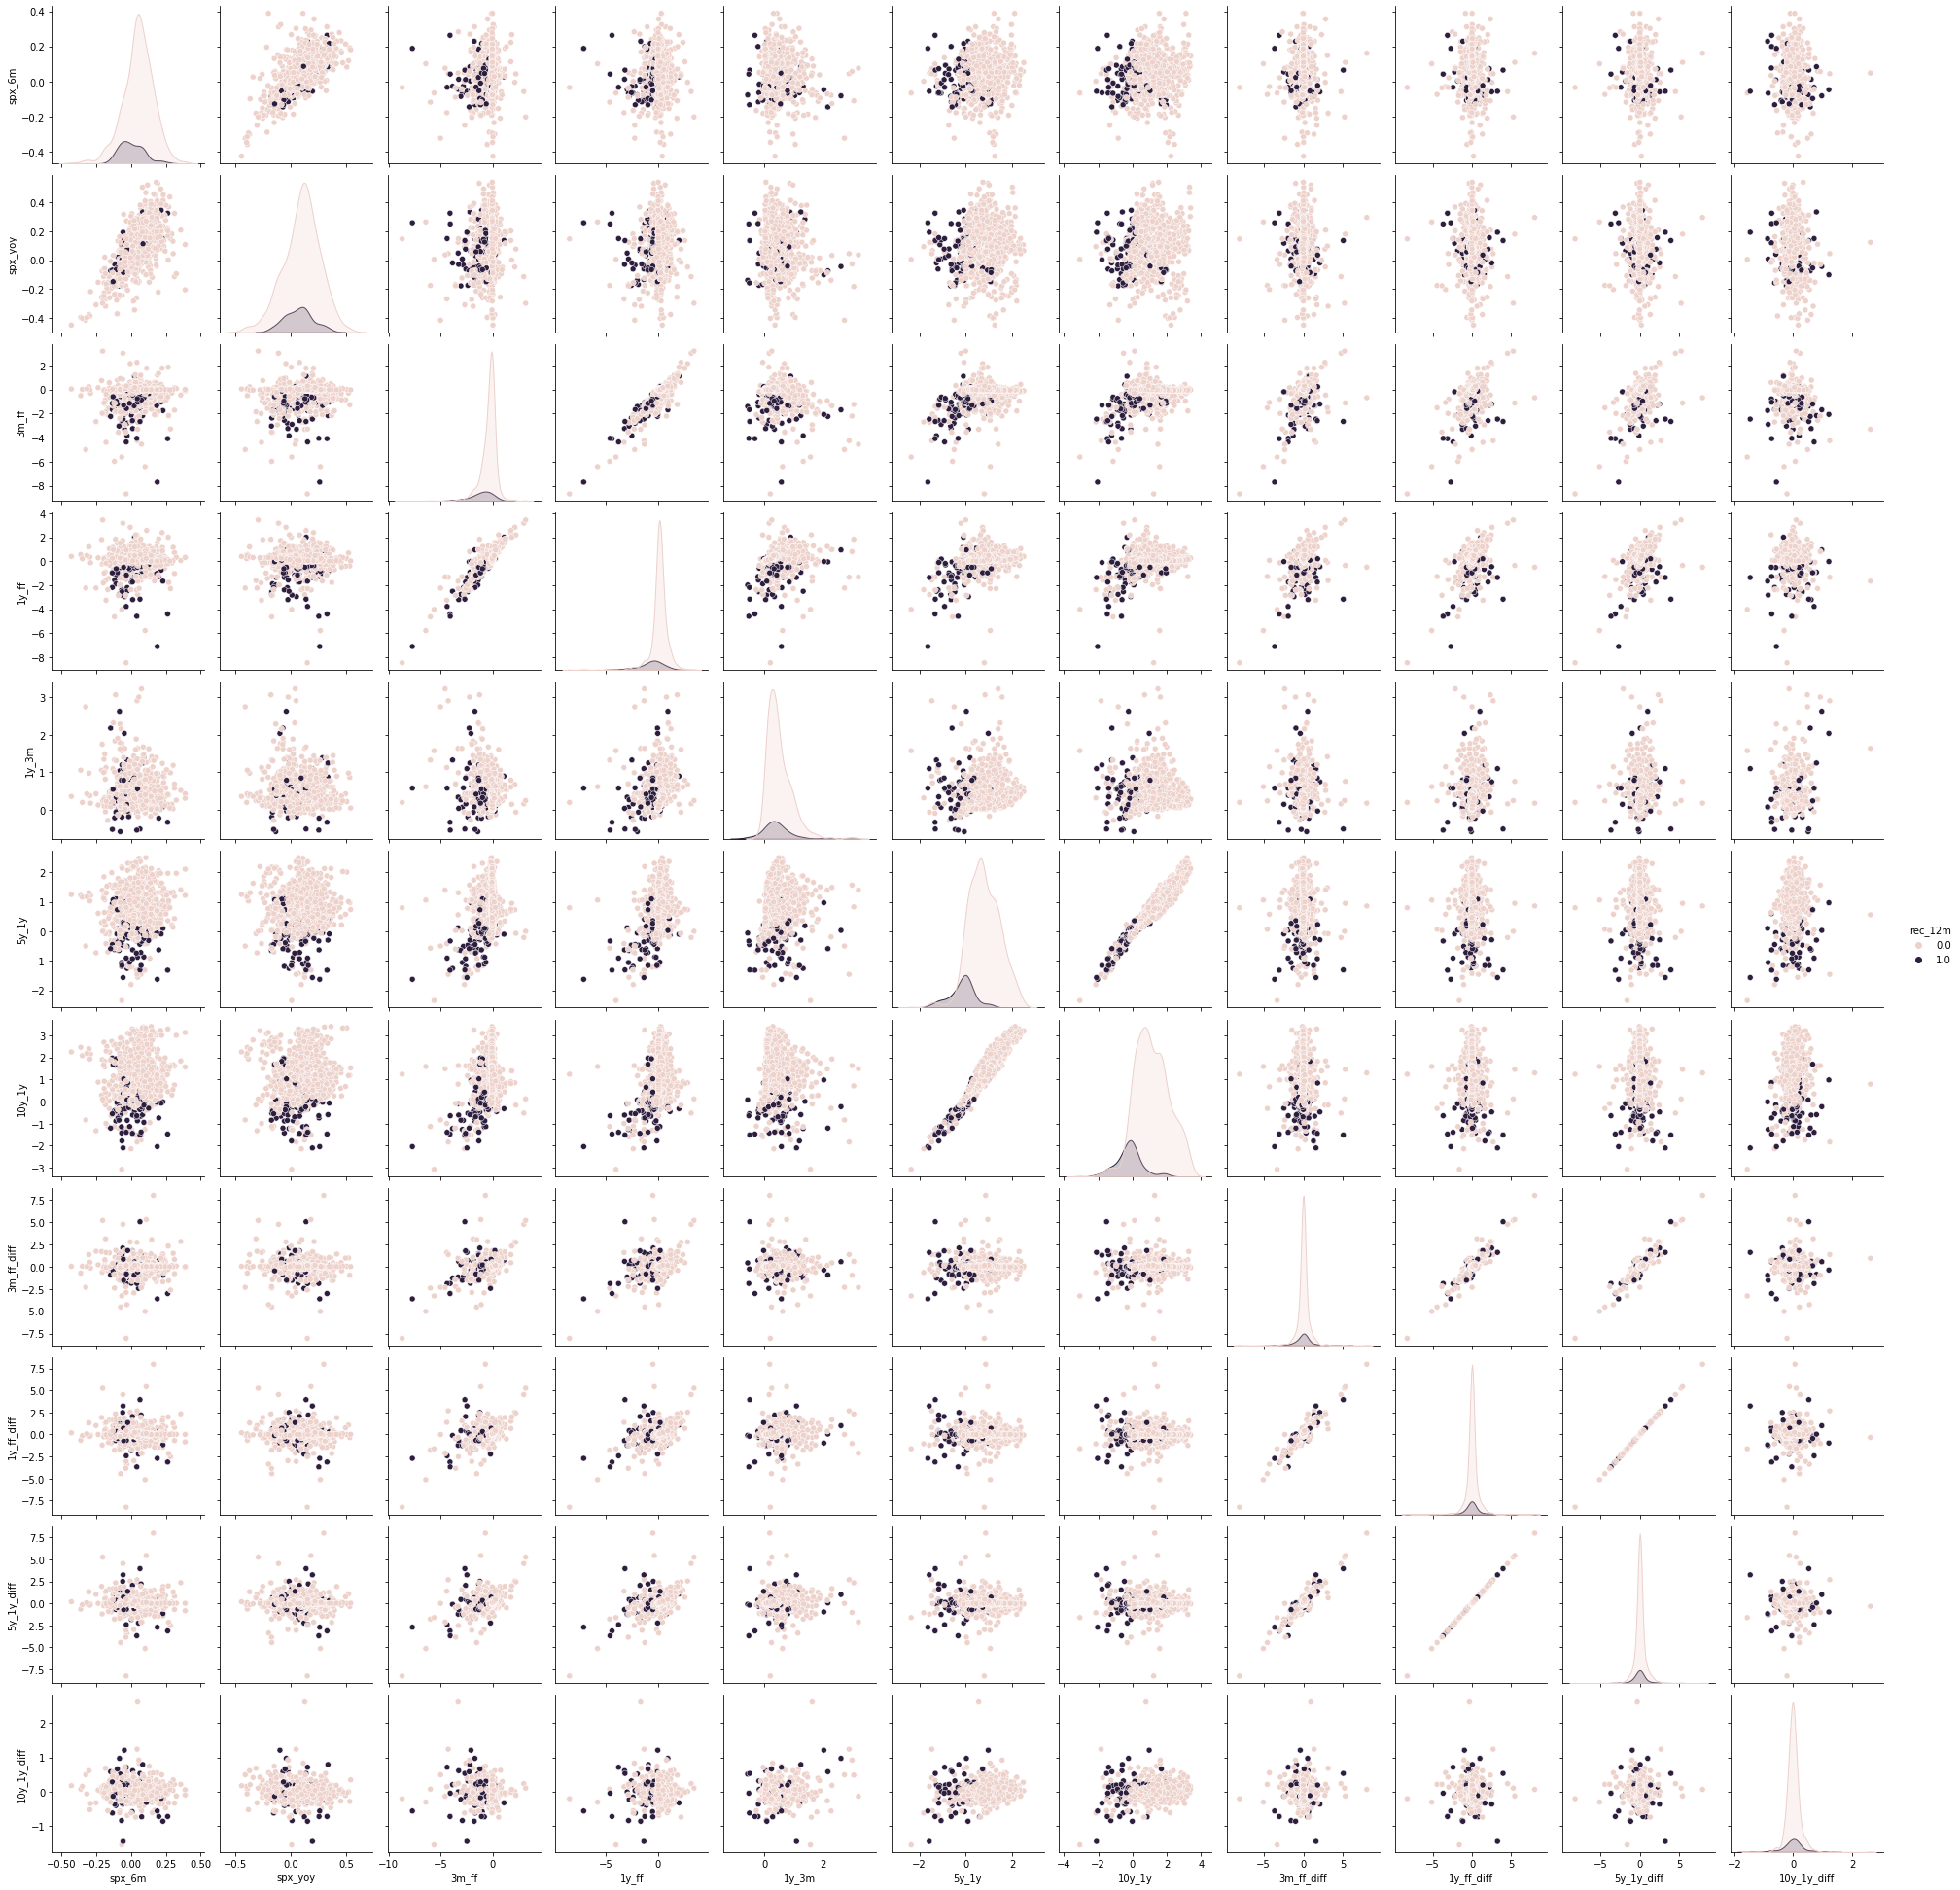

In [30]:
# Pairplot of the features to find patterns to classify recessions with a 12 month anticipation
sns.pairplot(market_data[['spx_6m', 'spx_yoy', '3m_ff', '1y_ff', '1y_3m', '5y_1y', '10y_1y', '3m_ff_diff', '1y_ff_diff', '5y_1y_diff', '10y_1y_diff', 'rec_12m']], hue='rec_12m')

In [31]:
# Correlation matrix
market_data[['spx_6m', 'spx_yoy', '3m_ff', '1y_ff', '1y_3m', '5y_1y', '10y_1y', '3m_ff_diff', '1y_ff_diff', '5y_1y_diff', '10y_1y_diff', 'ff_diff', 'rec_12m']].corr()

spx_6m   spx_yoy     3m_ff     1y_ff     1y_3m     5y_1y  \
spx_6m       1.000000  0.688389  0.106962  0.037573 -0.152101  0.137546   
spx_yoy      0.688389  1.000000  0.076297  0.009021 -0.145993  0.067641   
3m_ff        0.106962  0.076297  1.000000  0.890708 -0.284302  0.297000   
1y_ff        0.037573  0.009021  0.890708  1.000000  0.182588  0.359521   
1y_3m       -0.152101 -0.145993 -0.284302  0.182588  1.000000  0.115884   
5y_1y        0.137546  0.067641  0.297000  0.359521  0.115884  1.000000   
10y_1y       0.130906  0.062915  0.309227  0.311447 -0.011953  0.967523   
3m_ff_diff   0.004263 -0.015080  0.457358  0.433694 -0.074514  0.021386   
1y_ff_diff  -0.014985 -0.019044  0.430653  0.468609  0.056885 -0.005696   
5y_1y_diff  -0.014985 -0.019044  0.430653  0.468609  0.056885 -0.005696   
10y_1y_diff -0.038310 -0.089951 -0.036164  0.025809  0.132651  0.138521   
ff_diff      0.034290  0.057485 -0.373406 -0.437433 -0.114951 -0.057534   
rec_12m     -0.137861 -0.051366 -0.254797 -0.293927 -0.067286 -0.421687   

               10y_1y  3m_ff_diff  1y_ff_diff  5y_1y_diff  10y_1y_diff  \
spx_6m       0.130906    0.004263   -0.014985   -0.014985    -0.038310   
spx_yoy      0.062915   -0.015080   -0.019044   -0.019044    -0.089951   
3m_ff        0.309227    0.457358    0.430653    0.430653    -0.036164   
1y_ff        0.311447    0.433694    0.468609    0.468609     0.025809   
1y_3m       -0.011953   -0.074514    0.056885    0.056885     0.132651   
5y_1y        0.967523    0.021386   -0.005696   -0.005696     0.138521   
10y_1y       1.000000    0.024743   -0.004603   -0.004603     0.128051   
3m_ff_diff   0.024743    1.000000    0.933548    0.933548     0.075585   
1y_ff_diff  -0.004603    0.933548    1.000000    1.000000     0.013619   
5y_1y_diff  -0.004603    0.933548    1.000000    1.000000     0.013619   
10y_1y_diff  0.128051    0.075585    0.013619    0.013619     1.000000   
ff_diff     -0.057727   -0.891452   -0.909384   -0.909384    -0.327357   
rec_12m     -0.412810   -0.023054   -0.019566   -0.019566    -0.016640   

              ff_diff   rec_12m  
spx_6m       0.034290 -0.137861  
spx_yoy      0.057485 -0.051366  
3m_ff       -0.373406 -0.254797  
1y_ff       -0.437433 -0.293927  
1y_3m       -0.114951 -0.067286  
5y_1y       -0.057534 -0.421687  
10y_1y      -0.057727 -0.412810  
3m_ff_diff  -0.891452 -0.023054  
1y_ff_diff  -0.909384 -0.019566  
5y_1y_diff  -0.909384 -0.019566  
10y_1y_diff -0.327357 -0.016640  
ff_diff      1.000000  0.041988  
rec_12m      0.041988  1.000000

In [32]:
# Select inputs for the fourth model
y_4 = market_data['rec_12m'].dropna()
X_4 =  market_data[['spx_6m', 'spx_yoy', '3m_ff', '1y_ff', '1y_3m','5y_1y', '10y_1y']].loc[y_4.index]

# Split the data into training and testing sets, and transform training data to address class imbalance using ADASYN
X_train, X_test, y_train, y_test = train_test_split(X_4, y_4, test_size=0.2, random_state=random_state, stratify=y_4)
X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)

In [33]:
# Create the model using a GradientBoostingClassifier
model4 = GradientBoostingClassifier(random_state=random_state, n_estimators=500, subsample=0.4, min_samples_leaf=8)

# Use a forward floating feature selector, using cross validation and the F1 score to choose between models 
sfs4 = SFS(model4, k_features = 5, forward=True, floating=True, scoring='f1', cv=5)
sfs4.fit(X_resampled, y_resampled)

# Visualize the different combination of features
sfs4.subsets_

{1: {'feature_idx': (5,),
  'cv_scores': array([0.72146119, 0.71681416, 0.85833333, 0.73417722, 0.77876106]),
  'avg_score': 0.7619093913953513,
  'feature_names': ('5y_1y',)},
 2: {'feature_idx': (3, 5),
  'cv_scores': array([0.84920635, 0.81545064, 0.87763713, 0.85943775, 0.76576577]),
  'avg_score': 0.8334995281109286,
  'feature_names': ('1y_ff', '5y_1y')},
 3: {'feature_idx': (1, 3, 5),
  'cv_scores': array([0.90612245, 0.85344828, 0.89878543, 0.904     , 0.84716157]),
  'avg_score': 0.8819035443990554,
  'feature_names': ('spx_yoy', '1y_ff', '5y_1y')},
 4: {'feature_idx': (0, 1, 3, 5),
  'cv_scores': array([0.9218107 , 0.84482759, 0.95081967, 0.896     , 0.88412017]),
  'avg_score': 0.8995156259200682,
  'feature_names': ('spx_6m', 'spx_yoy', '1y_ff', '5y_1y')},
 5: {'feature_idx': (0, 1, 2, 3, 5),
  'cv_scores': array([0.91633466, 0.90612245, 0.94693878, 0.91269841, 0.90295359]),
  'avg_score': 0.917009577008136,
  'feature_names': ('spx_6m', 'spx_yoy', '3m_ff', '1y_ff', '5y_1y'

In [34]:
# Transform the features
X_train_sfs = sfs4.transform(X_resampled)
X_test_sfs = sfs4.transform(X_test)

# Fit the model using the chosen features
model4.fit(X_train_sfs, y_resampled)

# Print the confusion matrix using the testing data
confusion_matrix(y_test, model4.predict(X_test_sfs))

array([[131,  11],
       [  4,  17]])

In [35]:
# To evaluate the model, use the classification report for imbalanced data
classification_report_imbalanced(y_test, model4.predict(X_test_sfs), output_dict=True)

{0.0: {'pre': 0.9703703703703703,
  'rec': 0.9225352112676056,
  'spe': 0.8095238095238095,
  'f1': 0.9458483754512635,
  'geo': 0.864184134687281,
  'iba': 0.7552540708143338,
  'sup': 142},
 1.0: {'pre': 0.6071428571428571,
  'rec': 0.8095238095238095,
  'spe': 0.9225352112676056,
  'f1': 0.6938775510204083,
  'geo': 0.864184134687281,
  'iba': 0.7383743664760754,
  'sup': 21},
 'avg_pre': 0.9235741876846172,
 'avg_rec': 0.9079754601226994,
 'avg_spe': 0.8240835606687158,
 'avg_f1': 0.9133858765982087,
 'avg_geo': 0.864184134687281,
 'avg_iba': 0.7530793849793435,
 'total_support': 163}

In [36]:
# Fit the first model on the entire transformed dataset
X = sfs1.transform(X)
X_resampled, y_resampled = ADASYN().fit_resample(X, y)
model.fit(X_resampled, y_resampled)

GradientBoostingClassifier(min_samples_leaf=8, n_estimators=300, random_state=1,
                           subsample=0.4)

In [37]:
# Fit the second model on the entire transformed dataset
X_2 = sfs2.transform(X_2)
X_resampled, y_resampled = ADASYN().fit_resample(X_2, y_2)
model2.fit(X_resampled, y_resampled)

GradientBoostingClassifier(min_samples_leaf=8, n_estimators=500, random_state=1,
                           subsample=0.4)

In [38]:
# Fit the third model on the entire transformed dataset
X_3 = sfs3.transform(X_3)
X_resampled, y_resampled = ADASYN().fit_resample(X_3, y_3)
model3.fit(X_resampled, y_resampled)

GradientBoostingClassifier(min_samples_leaf=8, n_estimators=500, random_state=1,
                           subsample=0.4)

In [39]:
# Fit the fourth model on the entire transformed dataset
X_4 = sfs4.transform(X_4)
X_resampled, y_resampled = ADASYN().fit_resample(X_4, y_4)
model4.fit(X_resampled, y_resampled)

GradientBoostingClassifier(min_samples_leaf=8, n_estimators=500, random_state=1,
                           subsample=0.4)

In [40]:
# Create columns using the predictions
market_data['rec_prob'] = model.predict_proba(market_data[list(sfs1.subsets_[6]['feature_names'])])[:, 1]
market_data['rec_3m_prob'] = model2.predict_proba(market_data[list(sfs2.subsets_[6]['feature_names'])])[:, 1]
market_data['rec_6m_prob'] = model3.predict_proba(market_data[list(sfs3.subsets_[6]['feature_names'])])[:, 1]
market_data['rec_12m_prob'] = model4.predict_proba(market_data[list(sfs4.subsets_[5]['feature_names'])])[:, 1]

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


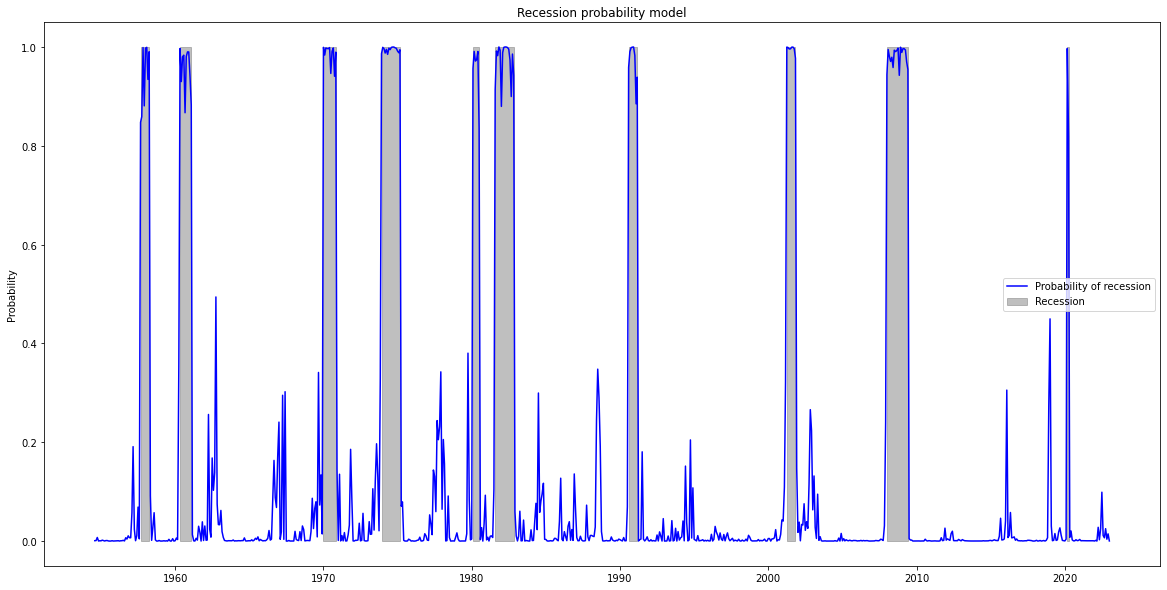

In [41]:
# Plot the data using gray shading for recessionary periods
import matplotlib.pyplot as plt
market_data.index = pd.to_datetime(market_data.index)
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(market_data.index, market_data.rec_prob, color='blue')
ax.fill_between(market_data.index, market_data.rec, where=(market_data.rec==1), color='gray', alpha=0.5)
plt.legend(['Probability of recession', 'Recession'])
plt.ylabel('Probability')
plt.title('Recession probability model')
plt.show()
plt.close()

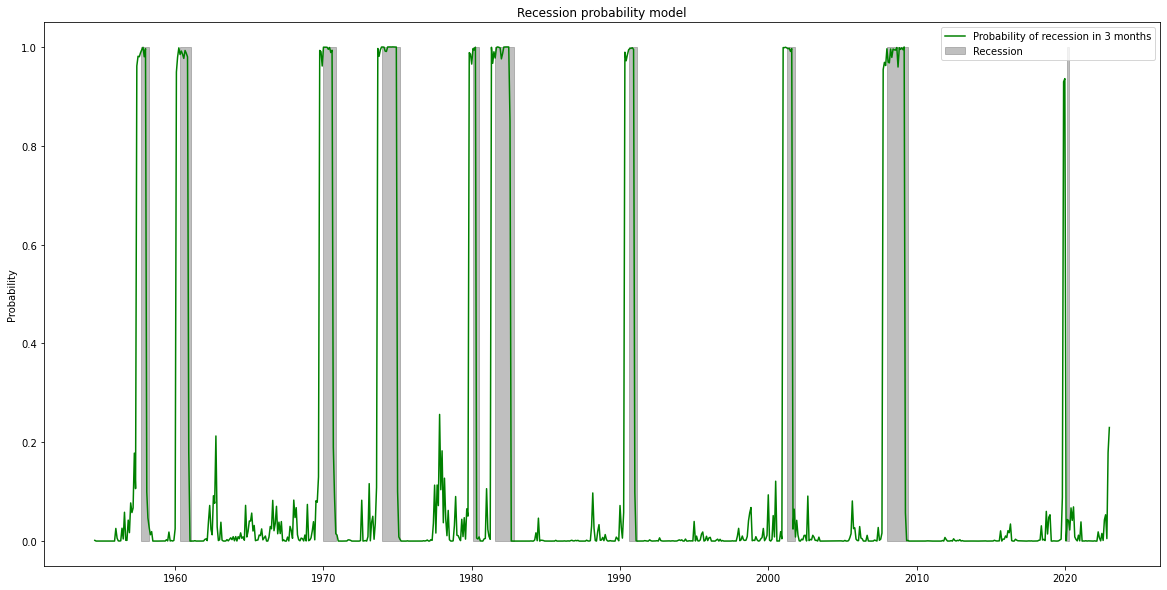

In [42]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(market_data.index, market_data.rec_3m_prob, color='green')
ax.fill_between(market_data.index, market_data.rec, where=(market_data.rec==1), color='gray', alpha=0.5)
plt.legend(['Probability of recession in 3 months', 'Recession'])
plt.ylabel('Probability')
plt.title('Recession probability model')
plt.show()
plt.close()

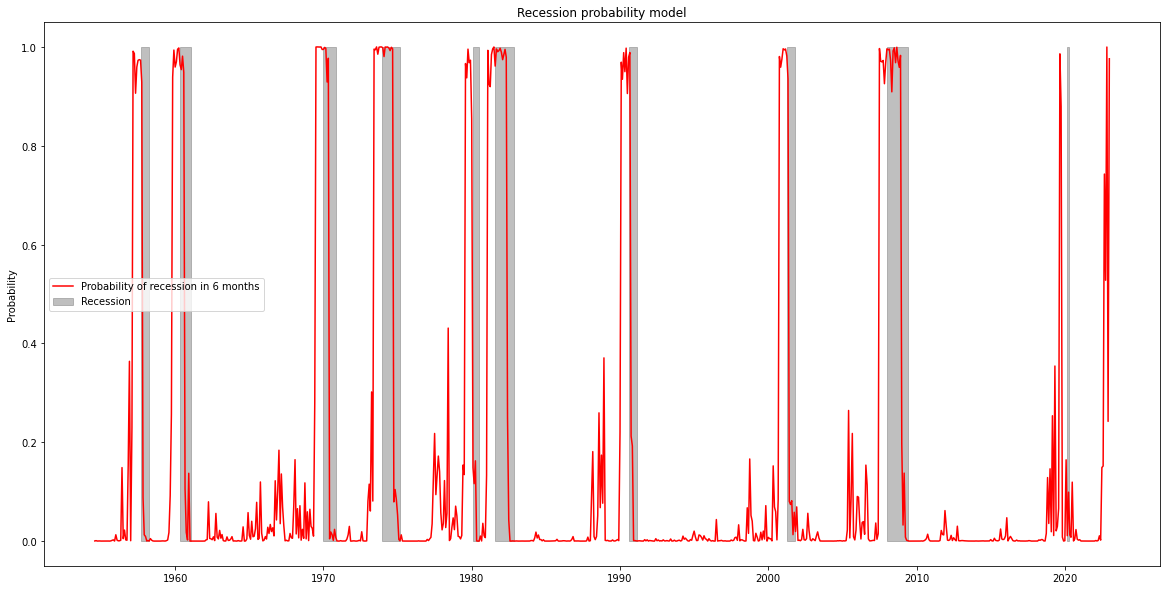

In [43]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(market_data.index, market_data.rec_6m_prob, color='red')
ax.fill_between(market_data.index, market_data.rec, where=(market_data.rec==1), color='gray', alpha=0.5)
plt.legend(['Probability of recession in 6 months', 'Recession'])
plt.ylabel('Probability')
plt.title('Recession probability model')
plt.show()
plt.close()

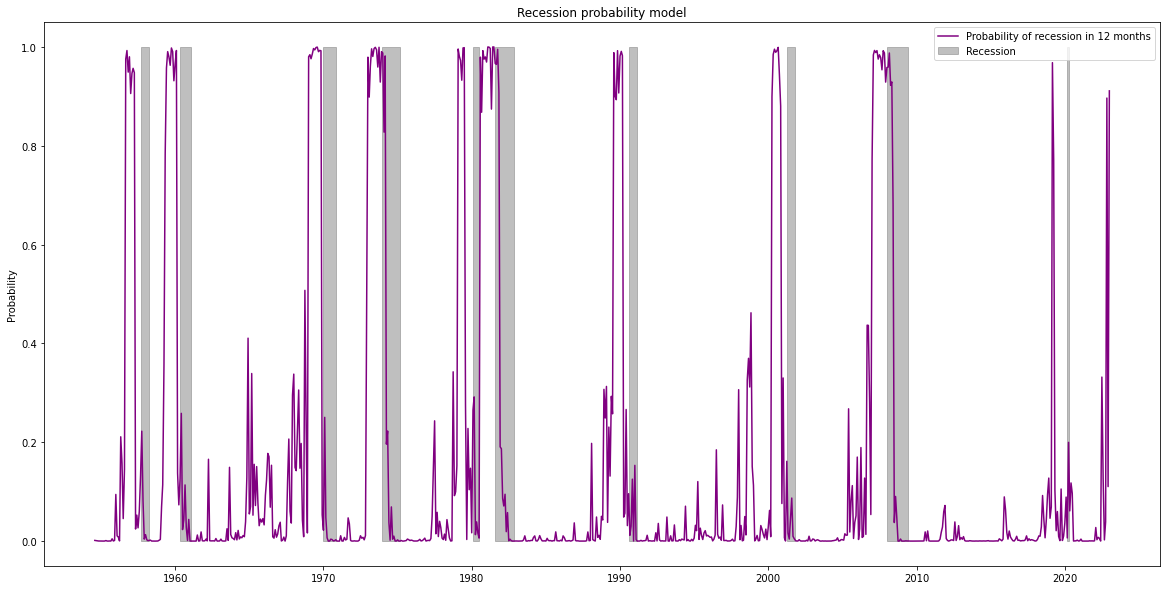

In [44]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(market_data.index, market_data.rec_12m_prob, color='purple')
ax.fill_between(market_data.index, market_data.rec, where=(market_data.rec==1), color='gray', alpha=0.5)
plt.legend(['Probability of recession in 12 months', 'Recession'])
plt.ylabel('Probability')
plt.title('Recession probability model')
plt.show()
plt.close()